In [172]:
import CSV
using DataFrames
# using StatsBase
include("pred_funcs.jl")
using MLJ
# import MLJBase
import TableView.showtable
using Plots
import FileIO
# using Statistics

In [ ]:
using Turing, Distributions


# Import MCMCChains, Plots, and StatsPlots for visualizations and diagnostics.
using MCMCChains, StatsPlots

# We need a logistic function, which is provided by StatsFuns.
using StatsFuns: logistic

using Random
Random.seed!(0);

using StatsBase
import MLJBase
setprogress!(true)

In [ ]:
MissingImputator = @load MissingImputator pkg="BetaML"

XGBoostClassifier = @load XGBoostClassifier;  # loads code defining a model type
LogisticClassifier = @load LogisticClassifier pkg="MLJLinearModels";  # loads code defining a model type
AdaBoostStumpClassifier = @load AdaBoostStumpClassifier;  # loads code defining a model type
EvoTreeClassifier = @load EvoTreeClassifier
GradientBoostingClassifier = @load GradientBoostingClassifier
EvoTreeGaussian = @load EvoTreeGaussian
SVC = @load SVC

In [445]:
sample_key, xold, y, train, test = FileIO.load("cleaned_data.jld2","sample_key","x" ,"y" , "train", "test");
xold.col1=collect(1:nrow(xold));

In [446]:
# xindel = filter(xs->xs.REF_I>0.5 || xs.ALT_I>0.5, xold);

In [447]:
# yindel = y[xindel.col1];
# select!(xindel,Not(:col1));

In [448]:
xsnv = filter(xs->xs.REF_I<0.5 && xs.ALT_I<0.5, xold);

In [449]:
ysnv = y[xsnv.col1];
sample_keysnv = sample_key[xsnv.col1]
select!(xsnv,Not(:col1));

In [450]:
# ? MissingImputator

In [451]:
todel = []
for i in names(xindel)
    if occursin("Pind",i)
       push!(todel,i)
    end
end

In [452]:
select!(xsnv, Not(todel));

In [453]:
train, test = partition(eachindex(ysnv), 0.7, stratify=ysnv,  shuffle=true, rng=12344);

In [454]:
transform_standardizer!(xsnv,fit_standardizer(xsnv[train,:]));

In [455]:
stmach = machine(MissingImputator(K=5),xsnv) 
@time sttran = fit!(stmach,verbosity=1)

 27.117133 seconds (121.37 M allocations: 25.706 GiB, 17.39% gc time)


┌ Info: Training Machine{MissingImputator,…} @946.
└ @ MLJBase /Users/alexpanchot/.julia/packages/MLJBase/W4gFl/src/machines.jl:391


Machine{MissingImputator,…} @946 trained 1 time; caches data
  args: 
    1:	Source @195 ⏎ `Table{Union{AbstractVector{Union{Missing, Continuous}}, AbstractVector{Continuous}}}`


In [456]:
tt = MLJ.transform(sttran,xsnv);

In [457]:
x = copy(xsnv);
y = copy(ysnv);

In [458]:
for i in 1:ncol(x)
    x[:,i] = tt[i]
end

In [459]:
disallowmissing!(x);

In [460]:

x,y,train = sampler(x,y,train,"over",0.1);

ratio: 0.004359831419851766
number of new: 1316


In [461]:
y = coerce(copy(y),OrderedFactor);

# ===

In [462]:
# info(LogisticClassifier)

In [463]:

r = [
    range(EvoTreeClassifier(), :max_depth, lower=1,upper=4),
    range(EvoTreeClassifier(), :η, lower=0.0,upper=1.0),
    range(EvoTreeClassifier(), :γ, lower=0.0,upper=1.0),
    range(EvoTreeClassifier(), :λ, lower=0.0,upper=1.0),
    range(EvoTreeClassifier(), :α, lower=0.0,upper=1.0),
#     range(EvoTreeClassifier(), :min_weight, lower=0.0,upper=1.0),
#     range(EvoTreeClassifier(), :nrounds, lower=1,upper=20),
    
    
#     range(LogisticClassifier(), :lambda, lower=0.0,upper=1.0),
#     range(LogisticClassifier(), :gamma, lower=0.0,upper=1.0),

]

5-element Vector{MLJBase.NumericRange{T, MLJBase.Bounded, Symbol} where T}:
 typename(MLJBase.NumericRange)(Int64, :max_depth, ... )
 typename(MLJBase.NumericRange)(Float64, :η, ... )
 typename(MLJBase.NumericRange)(Float64, :γ, ... )
 typename(MLJBase.NumericRange)(Float64, :λ, ... )
 typename(MLJBase.NumericRange)(Float64, :α, ... )

In [464]:
self_tune = TunedModel(
#     model=LogisticClassifier(penalty=:l2),
#     model=SVC(probability=true),
    model=EvoTreeClassifier(),
    resampling=StratifiedCV(nfolds=5, rng=123),
#     tuning=Grid(resolution=2), 
    tuning=LatinHypercube(),
    range = r,
#     range = range(SVC(), :degree, lower=1,upper=6),
    n=20,
    operation=predict_mode, # use for probabalistic 
    measure = fnr,  # use for deterministic or with predict_mode for probab 
#     measure = brier_loss # use for probabalistic 
)

machbest = machine(self_tune,x[train,:],y[train])

evaluate!(machbest,verbosity=2,resampling=StratifiedCV(nfolds=5, rng=123))
# MLJ.save("xgb_varscan.jlso", machbest)

┌ Info: Training Machine{ProbabilisticTunedModel{LatinHypercube,…},…} @953.
└ @ MLJBase /Users/alexpanchot/.julia/packages/MLJBase/W4gFl/src/machines.jl:391
┌ Info: Attempting to evaluate 20 models.
└ @ MLJTuning /Users/alexpanchot/.julia/packages/MLJTuning/efiDR/src/tuned_models.jl:685
Evaluating over 20 metamodels: 100%[=========================] Time: 0:00:08
┌ Info: Training Machine{ProbabilisticTunedModel{LatinHypercube,…},…} @953.
└ @ MLJBase /Users/alexpanchot/.julia/packages/MLJBase/W4gFl/src/machines.jl:391
┌ Info: Attempting to evaluate 20 models.
└ @ MLJTuning /Users/alexpanchot/.julia/packages/MLJTuning/efiDR/src/tuned_models.jl:685
Evaluating over 20 metamodels: 100%[=========================] Time: 0:00:08
Evaluating over 5 folds:  40%[==========>              ]  ETA: 0:00:25┌ Info: Training Machine{ProbabilisticTunedModel{LatinHypercube,…},…} @953.
└ @ MLJBase /Users/alexpanchot/.julia/packages/MLJBase/W4gFl/src/machines.jl:391
┌ Info: Attempting to evaluate 20 models.
└

PerformanceEvaluation object with these fields:
  measure, measurement, operation, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_pairs
Extract:
┌─────────────────────────────────────────────┬─────────────┬───────────┬───────
│ measure                                     │ measurement │ operation │ per_ ⋯
├─────────────────────────────────────────────┼─────────────┼───────────┼───────
│ LogLoss(tol = 2.22045e-16)\e @674\e │ 0.0668      │ predict   │ [0.0 ⋯
└─────────────────────────────────────────────┴─────────────┴───────────┴───────
                                                                1 column omitted


In [465]:
yhat=MLJ.predict_mode(machbest, x[test,:]);
# yhat=MLJ.predict(machbest, x[test,:]);

In [466]:
ConfusionMatrix()(yhat,y[test])

              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │    false    │    true     │
├─────────────┼─────────────┼─────────────┤
│    false    │    5898     │      1      │
├─────────────┼─────────────┼─────────────┤
│    true     │      0      │     24      │
└─────────────┴─────────────┴─────────────┘


In [471]:
aa = DataFrame(x1=yhat,x2=y[test],sample_key=sample_keysnv[test])
filter(x->x.x1==false && x.x2==true ,aa).sample_key


1-element Vector{String}:
 "272341_1_1000 4:106155751 G>A"

In [479]:
report(machbest).best_report.feature_importances

124-element Vector{Pair{String, Float64}}:
                      "pon_pvalue_Vardict" => 0.9337836400399512
                        "ODDRATIO_Vardict" => 0.04496437790518068
 "total_greater_than_min_alt_count_Lofreq" => 0.011944746054660355
                           "AltRev_Lofreq" => 0.003982184971054397
                            "gt_AF_Mutect" => 0.0029717066051171566
                            "GERMQ_Mutect" => 0.002353344424036084
                           "RefRev_Mutect" => 0.0
                      "FILTER_Lofreq_PASS" => 0.0
                 "VARIANT_CLASS_insertion" => 0.0
                "VARIANT_CLASS_DUP:TANDEM" => 0.0
                          "revbias_Mutect" => 0.0
                           "RefRev_Lofreq" => 0.0
                           "AltFwd_Mutect" => 0.0
                                           ⋮
                  "FILTER_Mutect_position" => 0.0
                           "RefFwd_Lofreq" => 0.0
                           "gt_AF_Vardict" => 0.0
            

# ====

In [480]:
y_tur = [i==true ? true : false for i in y];

In [482]:
xtur = select(x, ["pon_pvalue_Vardict","ODDRATIO_Vardict","total_greater_than_min_alt_count_Lofreq",
       "AltRev_Lofreq", "gt_AF_Mutect", "GERMQ_Mutect"]);

In [483]:
@model function logistic_regression(x, y, n, σ)
    intercept ~ Normal(0, σ)
    
#     params = []
#     for i = 1:ncol(x)
#         temp ~ Normal(0, σ)
#         push!(params,temp)
#     end
#     params = [
#         p1 ~ Normal(0, σ)
#         p2 ~ Normal(0, σ)
#         p3 ~ Normal(0, σ)
#         p4 ~ Normal(0, σ)
#         p5 ~ Normal(0, σ)
#         p6 ~ Normal(0, σ)
#     ]
    p1 ~ Normal(0, σ)
    p2 ~ Normal(0, σ)
    p3 ~ Normal(0, σ)
    p4 ~ Normal(0, σ)
    p5 ~ Normal(0, σ)
    p6 ~ Normal(0, σ)
    
    for i = 1:n
#         v = logistic(intercept + sum(params .* Vector(x[i, :]) ) )
        v = logistic(intercept + p1 * x[i, 1] + p2 * x[i, 2] + p3 * x[i, 3] +
            p4 * x[i, 4] + p5 * x[i, 5] + p6 * x[i, 6] )
        y[i] ~ Bernoulli(v)
    end
end;

In [484]:
showtable(x[1:10,1:4])

WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[""], Dict{Symbol, Any}(:style => Dict("height" => "0", "padding" => "0", "background-color" => "#F5F7F7", "color" => "#1c1f20", "font-family" => "-apple-system, BlinkMacSystemFont, \"Segoe UI\", Roboto, Oxygen-Sans, Ubuntu, Cantarell, \"Helvetica Neue\", sans-serif"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[], Dict{Symbol, Any}(:id => "grid-29dfe1f0", :className => "ag-theme-balham", :style => Dict("height" => "330px", "width" => "100%")))], Dict{Symbol, Any}()), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("onCellKeyDown" => (Observable{Any} with 0 listeners. Value:
nothing, nothing), "onRowClicked" => (Observable{Any} with 0 listeners. Value:
nothing, nothing), "onCellDoubleClicked" => (Observable{Any} with 0 listeners. Value:
nothing, nothing), "onCellClicked" => (Observable{Any} with 0 listeners. Value:
nothing, nothing), "onCellFocused" => (Observable{Any} with 0 listeners. Value:
nothing, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", nothing, "/Users/alexpanchot/.julia/packages/TableView/CaHPi/src/rowNumberRenderer.js"), WebIO.Asset("js", nothing, "/Users/alexpanchot/.julia/packages/TableView/CaHPi/deps/ag-grid-25.2.0/ag-grid.js"), WebIO.Asset("css", nothing, "/Users/alexpanchot/.julia/packages/TableView/CaHPi/deps/ag-grid-25.2.0/ag-grid.css"), WebIO.Asset("css", nothing, "/Users/alexpanchot/.julia/packages/TableView/CaHPi/deps/ag-grid-25.2.0/ag-grid-light.css"), WebIO.Asset("css", nothing, "/Users/alexpanchot/.julia/packages/TableView/CaHPi/deps/ag-grid-25.2.0/ag-grid-dark.css")], Dict{Any, Any}(), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00000001613d2a90, Task (runnable) @0x00000001613d2a90), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = ((function (RowNumberRenderer,agGrid){var gridOptions={\"onCellFocused\":(function (ev){var x={}; (ev.rowIndex!==undefined) ? (x[\"rowIndex\"]=(ev.rowIndex+1)) : undefined; (ev.colDef!==undefined) ? (x[\"column\"]=ev.colDef.headerName) : undefined; return WebIO.setval({\"name\":\"onCellFocused\",\"scope\":\"8736446077734475778\",\"id\":\"17964819084457975218\",\"type\":\"observable\"},x)}),\"onCellValueChanged\":(function (){return }),\"rowSelection\":\"multiple\",\"multiSortKey\":\"ctrl\",\"columnDefs\":[{\"filter\":false,\"editable\":false,\"headerTooltip\":\"\",\"field\":\"__row__\",\"headerName\":\"Row\",\"sortable\":true,\"type\":\"numericColumn\",\"cellRenderer\":\"rowNumberRenderer\",\"resizable\":true},{\"filter\":\"agNumberColumnFilter\",\"editable\":false,\"headerTooltip\":\"Float64\",\"field\":\"QUAL_Vardict\",\"headerName\":\"QUAL_Vardict\",\"sortable\":true,\"type\":\"numericColumn\",\"resizable\":true},{\"filter\":\"agNumberColumnFilter\",\"editable\":false,\"headerTooltip\":\"Float64\",\"field\":\"PMEAN_Vardict\",\"headerName\":\"PMEAN_Vardict\",\"sortable\":true,\"type\":\"numericColumn\",\"resizable\":true},{\"filter\":\"agNumberColumnFilter\",\"editable\":false,\"headerTooltip\":\"Float64\",\"field\":\"ReadQual_Vardict\",\"headerName\":\"ReadQual_Vardict\",\"sortable\":true,\"type\":\"numericColumn\",\"resizable\":true},{\"filter\":\"agNumberColumnFilter\",\"editable\":false,\"headerTooltip\":\"Float64\",\"field\":\"SBF_Vardict\",\"headerName\":\"SBF_Vardict\",\"sortable\":true,\"type\":\"numericColumn\",\"resizable\":true}],\"onCellDoubleClicked\":(function (ev){var x={}; (ev.rowIndex!==undefined) ? (x[\"rowIndex\"]=(ev.rowIndex+1)) : undefined; (ev.colDef!==undefined) ? (x[\"column\"]=ev.colDef.headerName) : undefined; return WebIO.setval({\"name\":\"onCellDoubleClicked\",\"scope\":\"8736446077734475778\",\"id\":\"11483467448261403269\",\"type\":\"observable\"},x)}),\"onRowClicked\":(function (ev){var x={}; (ev.rowIndex!==undefined) ? (x[\"rowIndex\"]=(ev.rowIndex+1

In [ ]:
n = length(y_tur[train]) #["gt_AF_Vardict","gt_AF_Mutect","gt_AF_Lofreq","pon_pvalue_Vardict"]

# Sample using HMC.
m = logistic_regression(x[train,1:16], y_tur[train], n, 1)
# chain = sample(m, HMC(0.2, 100), MCMCThreads(), 500, 5)

chain = sample(m, NUTS(50,0.65), MCMCThreads(), 100, 5, progress=true)
# describe(chain)

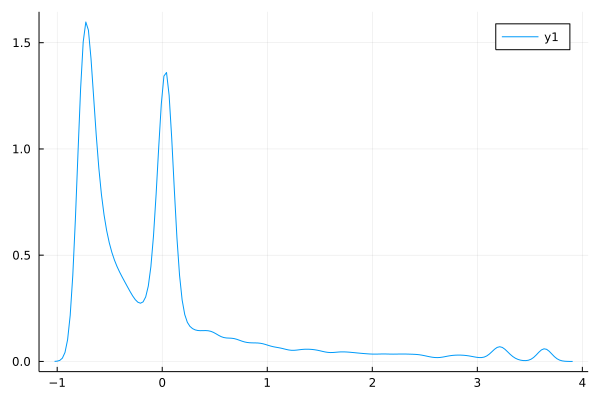

In [486]:
density(x.pon_pvalue_Vardict)

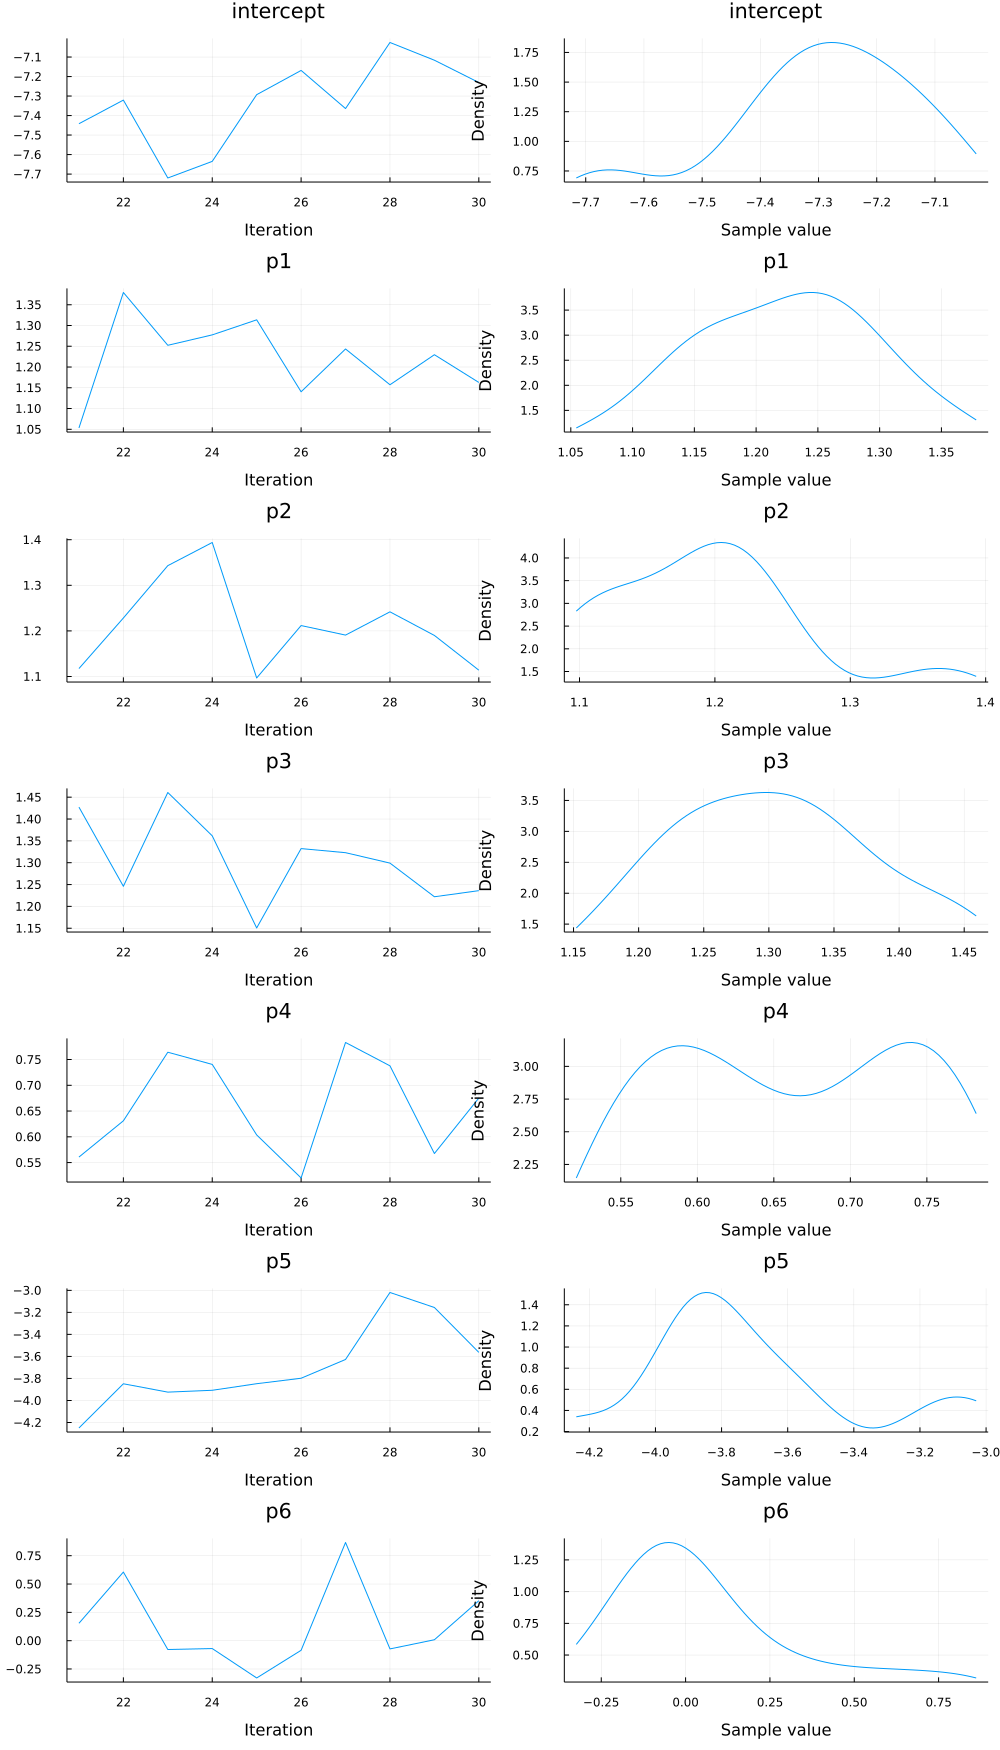

In [487]:
plot(chain)

In [488]:
? NUTS

search: NUTS ANUTS input_scitype DynamicNUTS ncodeunits InteractiveUtils



```
NUTS(n_adapts::Int, δ::Float64; max_depth::Int=5, Δ_max::Float64=1000.0, init_ϵ::Float64=0.0)
```

No-U-Turn Sampler (NUTS) sampler.

Usage:

```julia
NUTS()            # Use default NUTS configuration.
NUTS(1000, 0.65)  # Use 1000 adaption steps, and target accept ratio 0.65.
```

Arguments:

  * `n_adapts::Int` : The number of samples to use with adaptation.
  * `δ::Float64` : Target acceptance rate for dual averaging.
  * `max_depth::Int` : Maximum doubling tree depth.
  * `Δ_max::Float64` : Maximum divergence during doubling tree.
  * `init_ϵ::Float64` : Inital step size; 0 means automatically searching using a heuristic procedure.


In [489]:
function prediction_turing(x, chain)
    # Pull the means from each parameter's sampled values in the chain.
    intercept = mean(chain[:intercept])
    p1 = mean(chain[:p1])
    p2 = mean(chain[:p2])
    p3 = mean(chain[:p3])
    p4 = mean(chain[:p4])

    # Retrieve the number of rows.
    n = nrow(x)

    # Generate a vector to store our predictions.
    v = Vector{Float64}(undef, n)

    # Calculate the logistic function for each element in the test set.
    for i in 1:n
        v[i] = logistic(intercept + p1*x[i, 1] + p2*x[i,2] + p3*x[i,3] + p4*x[i,4] )
    end
    return v
end;

In [490]:
ypred = prediction_turing(x[test,["gt_AF_Vardict","gt_AF_Mutect","gt_AF_Lofreq","pon_pvalue_Vardict"]],chain);

In [491]:
yhat2 = [i>.2 ? true : false for i in ypred];

In [492]:
MLJ.ConfusionMatrix()(yhat2,y[test])


              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │    false    │    true     │
├─────────────┼─────────────┼─────────────┤
│    false    │    5861     │     18      │
├─────────────┼─────────────┼─────────────┤
│    true     │     37      │      7      │
└─────────────┴─────────────┴─────────────┘
